# ECG analysis project
### Author: Marian Petruk


### Import libraries, modules

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
import glob

from scipy.signal import butter, sosfilt, sosfilt_zi, sosfiltfilt, lfilter, lfilter_zi, filtfilt, sosfreqz, resample
from utils import hamilton_detector, christov_detector, findpeaks, engzee_detector
from ecg_detectors.ecgdetectors import Detectors, MWA, panPeakDetect, searchBack

np.random.seed(256)

warnings.filterwarnings('ignore')

### Traverse data directory

In [21]:
data_path = 'Part_A_S/biosignals_filtered/*/'
all_files = glob.glob(data_path + '/*.csv')
one_file = ''
for file in all_files[0:len(all_files)]:
    if file == 'Part_A_S/biosignals_filtered/091809_w_43/091809_w_43-PA4-023_bio.csv':
        one_file = file
one_file

'Part_A_S/biosignals_filtered/091809_w_43/091809_w_43-PA4-023_bio.csv'

In [22]:
df = pd.read_csv(one_file, sep='\t', header=0, index_col=None)
ecg_data = df[['time', 'ecg']]
ecg_data

,time,ecg
0,391,-124.945800
1,2344,-138.602200
2,4297,-128.055700
3,6250,-114.843800
4,8203,-120.054800
...,...,...
2811,5490625,61.109270
2812,5492578,43.857540
2813,5494531,-4.861115
2814,5496484,-14.621150


In [23]:
ecg_data['time']

0           391
1          2344
2          4297
3          6250
4          8203
         ...   
2811    5490625
2812    5492578
2813    5494531
2814    5496484
2815    5498438
Name: time, Length: 2816, dtype: int64

### Load raw ECG signal

### Plot raw ecg sample

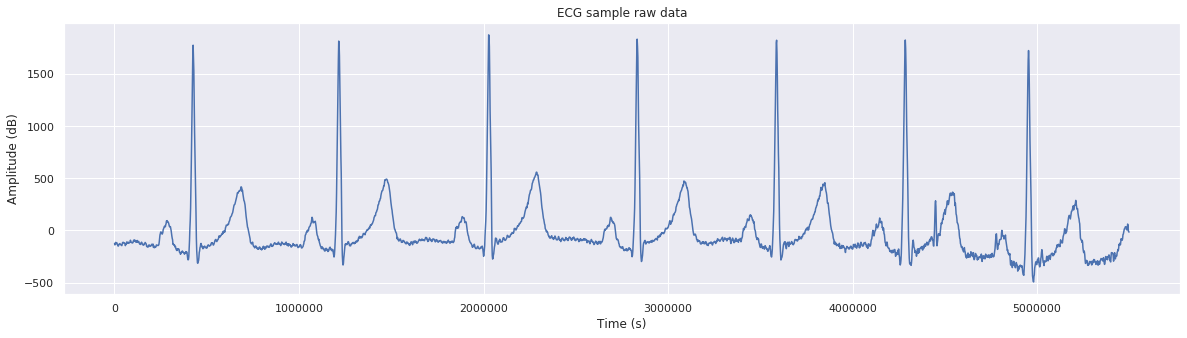

In [24]:
plt.figure(figsize=(20, 5))
plt.ylabel("Amplitude (dB)")
fs = 200
# Calculate time values in seconds
times = ecg_data['time'].values
data = ecg_data['ecg'].values
plt.plot(times, data)
plt.xlabel("Time (s)")
plt.title("ECG sample raw data")
plt.show()

### Filter the data from noise

#### **Butterworth Bandpass filter**

In [6]:
import pixiedust

Pixiedust database opened successfully


In [7]:
type(data)

numpy.ndarray

In [8]:
#%%pixie_debugger
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype="band", output="sos")
    return sos


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos,
                data)  # Filter data along one dimension using cascaded second-order sections. Using lfilter for each second-order section.
    return y


def butter_bandpass_filter_once(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    # Apply the filter to data. Use lfilter_zi to choose the initial condition of the filter.
    zi = sosfilt_zi(sos)
    z, _ = sosfilt(sos, data, zi=zi * data[0])
    return sos, z, zi


def butter_bandpass_filter_again(sos, z, zi):
    # Apply the filter again, to have a result filtered at an order the same as filtfilt.
    z2, _ = sosfilt(sos, z, zi=zi * z[0])
    return z2


def butter_bandpass_forward_backward_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos,
                    data)  # Apply a digital filter forward and backward to a signal.This function applies a linear digital filter twice, once forward and once backwards. The combined filter has zero phase and a filter order twice that of the original.
    return y

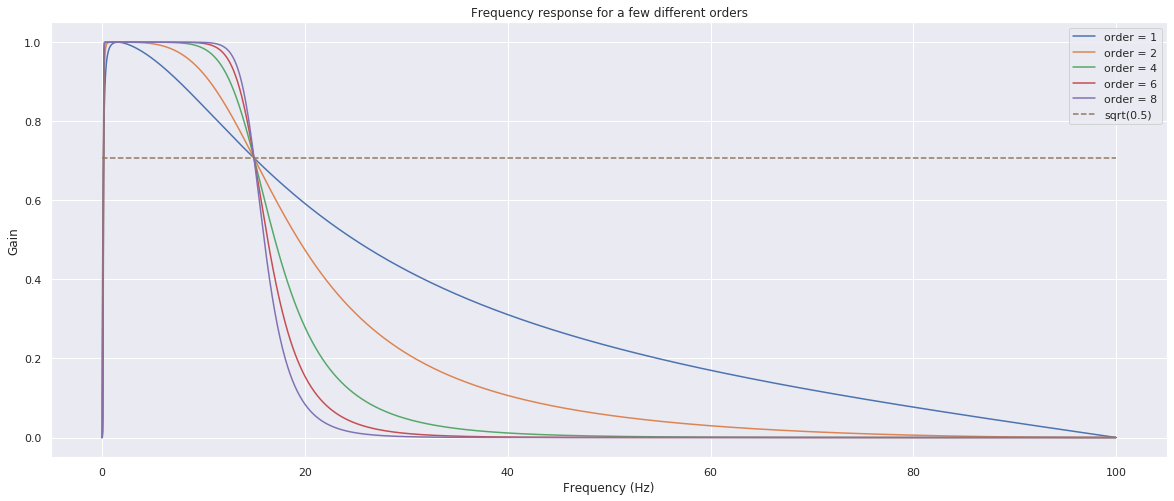

In [9]:
# Sample rate and desired cutoff frequencies (in Hz).
x = data
fs = 200  # corresponds to 60 beats per min (normal for human), assumed.
lowcut = 0.05 * 3.3  # 9.9 beats per min
highcut = 15  # 900 beats per min

# Plot the frequency response for a few different orders.
plt.figure(1, figsize=(20, 8))
plt.clf()
for order in [1, 2, 4, 6, 8]:
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = sosfreqz(sos, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         "--", label="sqrt(0.5)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain")
plt.title("Frequency response for a few different orders")
plt.grid(True)
plt.legend(loc="best")

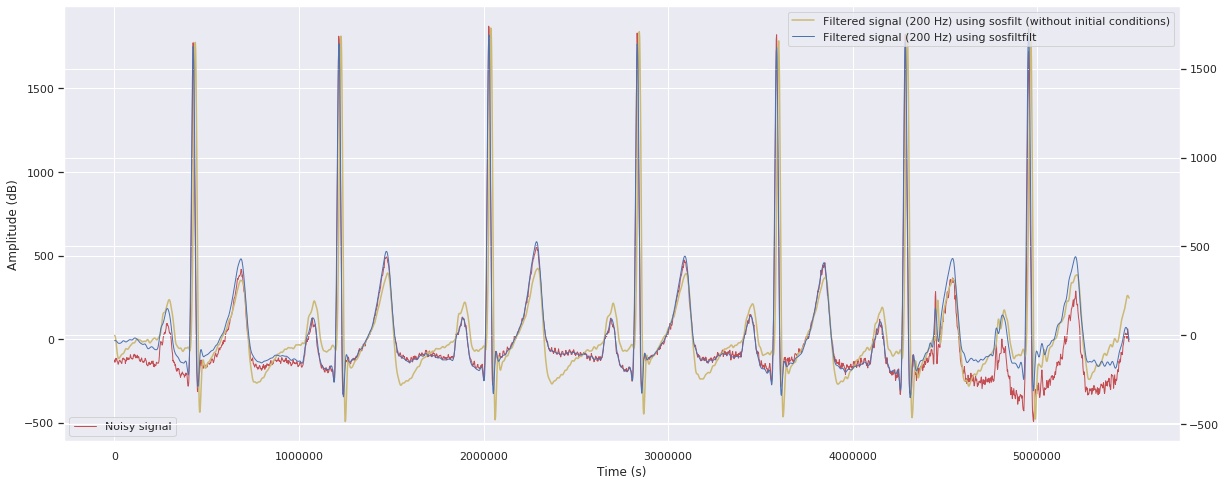

In [28]:
#%%pixie_debugger
plt.figure(2, figsize=(20, 8))
plt.clf()
plt.ylabel("Amplitude (dB)")
plt.xlabel("Time (s)")
plt.plot(times, x, "r", linewidth=1, label="Noisy signal")
plt.legend(loc="lower left")
plt.twinx()
plt.plot(times, butter_bandpass_filter(x, lowcut, highcut, fs, order=4), 'y',
         label="Filtered signal (%g Hz) using sosfilt (without initial conditions)" % fs)
y = butter_bandpass_forward_backward_filter(x, lowcut, highcut, fs, order=4)
plt.plot(times, y, 'b', linewidth=1, label="Filtered signal (%g Hz) using sosfiltfilt" % fs)

plt.axis("tight")
plt.legend(loc="upper right")
plt.savefig('filter_ECG.pdf')

As we can see, it is better to use `scipy.signal.sosfiltfilt` instead of `sosfilt` to apply the Butterworth filter. `sosfiltfilt` is the forward-backward filter. It applies the filter twice, once forward and once backward, resulting in zero phase delay.

#### Illustration of a phase delay/shift

Phase shift is any change that occurs in the phase of one quantity, or in the phase difference between two or more quantities. (c) Wikipedia 
<img width="300px" src="images/Phase_shift.png" alt="illustration of phase shift from wikipedia">

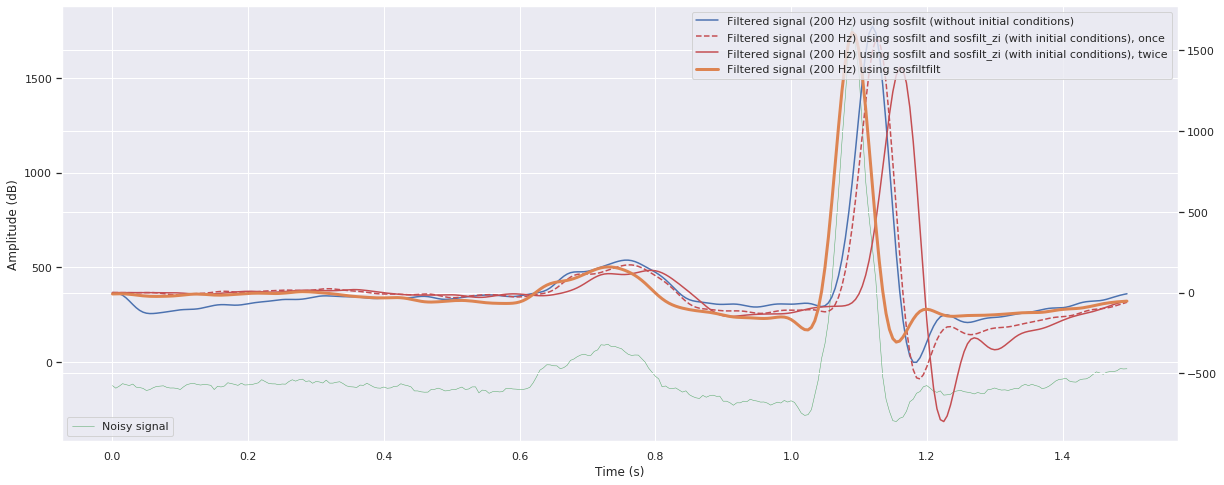

In [11]:
x = data[:300]
plt.figure(figsize=(20, 8))

plt.ylabel("Amplitude (dB)")
# Calculate time values in seconds
times = np.arange(x.shape[0], dtype='float') / fs
plt.xlabel("Time (s)")

plt.plot(times, x, "g", linewidth=0.5, label="Noisy signal")
plt.legend(loc="lower left")
plt.twinx()
plt.plot(times, butter_bandpass_filter(x, lowcut, highcut, fs, order=4),
         label="Filtered signal (%g Hz) using sosfilt (without initial conditions)" % fs)
sos, z, zi = butter_bandpass_filter_once(x, lowcut, highcut, fs, order=5)
plt.plot(times, z, "r--", label="Filtered signal (%g Hz) using sosfilt and sosfilt_zi (with initial conditions), once" % fs)
plt.plot(times, butter_bandpass_filter_again(sos, z, zi), "r",
         label="Filtered signal (%g Hz) using sosfilt and sosfilt_zi (with initial conditions), twice" % fs)
plt.plot(times, butter_bandpass_forward_backward_filter(x, lowcut, highcut, fs, order=4), linewidth=3,
         label="Filtered signal (%g Hz) using sosfiltfilt" % fs)
plt.grid(True)
plt.axis("tight")
plt.legend(loc="upper right")

plt.show()

We can see phase delay on filtered singal using `sosfilt` without initial conditions and on both stages of `sosfilt` with initial conditions (`sosfilt_zi`). However, `sosfiltfilt` - a forward-backward digital filter has **zero phase delay/shift**.

## QRS

QRS detection is difficult, not only because of the physiological variability of the QRS complexes, but also because of the various types of noise that can be present in the ECG signal. Noise sources include muscle noise, artifacts due to electrode motion, power-line interference, baseline wander and T waves with high frequency characteristics similar to QRS complexes.

### Detect R-peaks

#### Main detector that is used is pan-tompkins

In [12]:
def pan_tompkins_detector(raw_ecg, mwa, fs, N):
   
#     N = int(0.12 * fs)
#     mwa = MWA(squared, N)
#     mwa[:int(0.2 * fs)] = 0

    N = int(N / 100 * fs)
    mwa_peaks = panPeakDetect(mwa, fs)

    r_peaks = searchBack(mwa_peaks, raw_ecg, N)

    return r_peaks

In [13]:
#%%pixie_debugger
# Derivative - provides QRS slope information. The differences btw consecutive elements of an array.
differentiated_ecg_measurements = np.ediff1d(y)  

# Squaring - intensifies values received in derivative. 
# This helps restrict false positives caused by T waves with higher than usual spectral energies..
squared_ecg_measurements = differentiated_ecg_measurements ** 2

# Moving-window integration.
integration_window = 50  # Change proportionally when adjusting frequency (in samples)
integrated_ecg_measurements = np.convolve(squared_ecg_measurements, np.ones(integration_window))
print(integrated_ecg_measurements)
# Fiducial mark - peak detection on integrated measurements.
rpeaks = pan_tompkins_detector(data, integrated_ecg_measurements, fs, integration_window)
print(rpeaks)

[3.76829483e-01 4.75980963e-01 5.32015185e-01 ... 5.16273951e+02
 3.73051531e+02 1.96361868e+02]
[  56  146  218  622 1038 1450 1837 2194 2536]


In [18]:
from Ecg_preprocess import *

def getList(dict):
        return np.array(list(dict.keys()))
    
Ecg_preprocessor = Ecg_preprocess(x, lowcut, highcut, fs, order=4)
rpeaks_dict, Q, S = Ecg_preprocessor.tailor_rpeaks_length(data, rpeaks)
new_rpeaks = getList(rpeaks_dict)

In [19]:
rpeaks = new_rpeaks
rpeaks

array([ 218,  622, 1038, 1450, 1837, 2194, 2536])

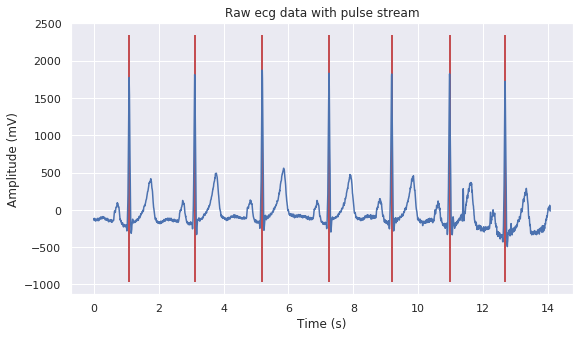

In [30]:
figsize = (9, 5)
name = one_file.split('/')[3][:-4]
plt.figure(figsize=figsize)

ymin = np.min(data)
ymax = np.max(data)
alpha = 0.2 * (ymax - ymin)
ymax += alpha
ymin -= alpha

# plt.figure(figsize=left_figsize)
# plt.subplot(626)
# plt.subplot2grid((6, 2), (5, 0))
# plt.clf()
plt.ylabel("Amplitude (mV)")
# Calculate time values in seconds
times = np.arange(data.shape[0], dtype='float') / fs
plt.xlabel("Time (s)")
plt.plot(times, data)
plt.vlines(rpeaks/fs, ymin, ymax,
           color="r",
           linewidth=1,
           label="R-peaks")
plt.title("Raw ecg data with pulse stream")
plt.savefig('./ecg-waves/' + name + '.jpg')

In [21]:
one_file

'Part_A_S/biosignals_filtered/091809_w_43/091809_w_43-PA4-023_bio.csv'

In [24]:
one_file.split('/')[3][:-4]

'091809_w_43-PA4-023_bio'